In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-09-15 14:52:03--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2025-09-15 14:52:03 (71.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"   # shortcut URL
filpath = tf.keras.utils.get_file("shakes.txt", shakespeare_url)
with open(filpath) as f:
    shakespeare_text = f.read()

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [4]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [5]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

In [6]:
text_vec_layer.get_vocabulary()

['',
 '[UNK]',
 np.str_(' '),
 np.str_('e'),
 np.str_('t'),
 np.str_('o'),
 np.str_('a'),
 np.str_('i'),
 np.str_('h'),
 np.str_('s'),
 np.str_('r'),
 np.str_('n'),
 np.str_('\n'),
 np.str_('l'),
 np.str_('d'),
 np.str_('u'),
 np.str_('m'),
 np.str_('y'),
 np.str_('w'),
 np.str_(','),
 np.str_('c'),
 np.str_('f'),
 np.str_('g'),
 np.str_('b'),
 np.str_('p'),
 np.str_(':'),
 np.str_('k'),
 np.str_('v'),
 np.str_('.'),
 np.str_("'"),
 np.str_(';'),
 np.str_('?'),
 np.str_('!'),
 np.str_('-'),
 np.str_('j'),
 np.str_('q'),
 np.str_('x'),
 np.str_('z'),
 np.str_('3'),
 np.str_('&'),
 np.str_('$')]

In [7]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2 # number of distinct chars without unk and padding
dataset_size = len(encoded)
dataset_size

1115394

In [8]:
n_tokens

39

In [9]:
dataset_size

1115394

In [10]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices(sequence)
  ds = ds.window(length +  1, shift = 1, drop_remainder=True)
  ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
  if shuffle:
    ds = ds.shuffle(100_000, seed=seed)
  ds = ds.batch(batch_size)
  return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [11]:
list(to_dataset(tf.range(10), 3))

[(<tf.Tensor: shape=(7, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6],
         [5, 6, 7],
         [6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(7, 3), dtype=int32, numpy=
  array([[1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6],
         [5, 6, 7],
         [6, 7, 8],
         [7, 8, 9]], dtype=int32)>)]

In [12]:
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

In [13]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

Building and Training the Chaar-RNN Mode

In [14]:
tf.random.set_seed(42)   #extra code - ensures reproducibilitys on CPU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")

])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'my_shakespeare_model.keras', monitor='val_accuracy', save_best_only=True)

In [15]:
history = model.fit(train_set, validation_data=valid_set, epochs=1,
                    callbacks=[model_ckpt])

   1869/Unknown 27s 12ms/step - accuracy: 0.3227 - loss: 2.3876

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1872/1872 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.3228 - loss: 2.3869 - val_accuracy: 0.4467 - val_loss: 1.8638


In [16]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X-2),  # no  or  tokens   # no <PAD>  or <UNK> tokens
    model
])

In [ ]:
# # extra code – downloads a pretrained model
# from pathlib import Path
# url = "https://github.com/enerrio/Generate-Shakespeare-Sonnets/blob/master/shakespeare_sonnet_model.h5"
# path = tf.keras.utils.get_file("shakespeare_model.h5", url, extract=True)
# model_path = Path(path).with_name("shakespeare_model")
# shakespeare_model = tf.keras.models.load_model(model_path)

In [17]:
import tensorflow as tf

input_text = ["To be or not to b"]
input_tensor = tf.constant(input_text)
y_proba = shakespeare_model.predict(input_tensor)[0,-1]
y_pred = tf.argmax(y_proba)
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


np.str_('a')

Generating Fake Shakespearean Text

In [18]:
import numpy as np
np.log([0.5, 0.4, 0.1, 1])

array([-0.69314718, -0.91629073, -2.30258509,  0.        ])

In [19]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])   # probas = 50%, 40%, 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 1, 1, 0, 0, 0]])>

In [20]:
def next_char(text, temperature=1):
  # Convert the input text to a tensor
  text_tensor = tf.constant([text])
  y_proba = shakespeare_model.predict(text_tensor)[0, -1:]
  rescaled_logits = tf.math.log(y_proba) / temperature
  char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
  return text_vec_layer.get_vocabulary()[char_id + 2]

In [21]:
def extend_text(text, n_chars=100, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

Stateful RNN

In [22]:
def to_dataset_for_stateful_rnn(sequence, length):
  ds = tf.data.Dataset.from_tensor_slices(sequence)
  ds = ds.window(length + 1, shift=length, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(length + 1))
  ds = ds.map(lambda window: tf.expand_dims(window, axis=0)) # Add batch dimension
  return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000], length)

stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [23]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

In [24]:
# extra code - shows one way to preapare a batched dataset for a statful RNN

import numpy as np

def to_non_overlapping_windows(sequence, length):
  ds = tf.data.Dataset.from_tensor_slices(sequence)
  ds = ds.window(length + 1, shift=length, drop_remainder=True)
  return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_Dataset_for_stateful_rnn(sequence, length,batch_size=32):
  parts = np.array_split(sequence, batch_size)
  datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
  ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
  return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)


list(to_batched_Dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]], dtype=int32)>)]

In [25]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.layers[1].reset_states()

In [26]:
model_ckpt =  tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model.keras",
    monitor="val_accuracy",
    save_best_only=True
    )

In [27]:
# warning: the following cell will take a while to run (possibly an hour if you are not using a GPU).

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(stateful_train_set, epochs=7,
                    validation_data=stateful_valid_set,
                    callbacks=[model_ckpt])

Epoch 1/7
9999/9999 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.4721 - loss: 1.7836 - val_accuracy: 0.5029 - val_loss: 1.6354
Epoch 2/7
9999/9999 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.5289 - loss: 1.5537 - val_accuracy: 0.5161 - val_loss: 1.5866
Epoch 3/7
9999/9999 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.5444 - loss: 1.4918 - val_accuracy: 0.5236 - val_loss: 1.5673
Epoch 4/7
9999/9999 ━━━━━━━━━━━━━━━━━━━━ 141s 8ms/step - accuracy: 0.5519 - loss: 1.4608 - val_accuracy: 0.5285 - val_loss: 1.5562
Epoch 5/7
9999/9999 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - accuracy: 0.5572 - loss: 1.4421 - val_accuracy: 0.5296 - val_loss: 1.5483
Epoch 6/7
9999/9999 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.5609 - loss: 1.4294 - val_accuracy: 0.5309 - val_loss: 1.5431
Epoch 7/7
9999/9999 ━━━━━━━━━━━━━━━━━━━━ 139s 14ms/step - accuracy: 0.5624 - loss: 1.4199 - val_accuracy: 0.5324 - val_loss: 1.5429


In [28]:
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim = n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [29]:
stateless_model.build(tf.TensorShape([None, None]))

In [30]:
stateless_model.set_weights(model.get_weights())

In [31]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X -2),      # no <PAD> or <UNK> tokens
    stateless_model
])

In [32]:
tf.random.set_seed(42)
print(extend_text("to be or not to be", temperature=0.01))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

Sentiment Analysis

In [33]:
import tensorflow as tf

In [34]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.O874IF_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.O874IF_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.O874IF_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [35]:
for review,label in raw_train_set.take(4):
  print(review.numpy()[:200], "...")
  print("Label:", label.numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting " ...
Label: 0
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However ' ...
Label: 0
b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun' ...
Label: 0
b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf' ...
Label: 1


In [36]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, label: reviews))

In [37]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, epochs=25, validation_data=valid_set)

Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 786ms/step - accuracy: 0.4410 - loss: 0.6965 - val_accuracy: 0.5028 - val_loss: 0.6931
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step - accuracy: 0.5173 - loss: 0.6926 - val_accuracy: 0.5032 - val_loss: 0.6932
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step - accuracy: 0.3418 - loss: 0.6988 - val_accuracy: 0.5028 - val_loss: 0.6932
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5362 - loss: 0.6911 - val_accuracy: 0.5028 - val_loss: 0.6934
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 592ms/step - accuracy: 0.5072 - loss: 0.6925 - val_accuracy: 0.5028 - val_loss: 0.6934
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step - accuracy: 0.4922 - loss: 0.6938 - val_accuracy: 0.5032 - val_loss: 0.6933
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - accuracy: 0.5150 - loss: 0.6919 - val_accuracy: 0.5040 - val_loss: 0.6933
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.5267 - loss: 0.6901 - val_accuracy: 0.5036 - val_loss: 0.

Masking

In [38]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size,mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4387 - loss: 0.6948 - val_accuracy: 0.4952 - val_loss: 0.6934
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step - accuracy: 0.6503 - loss: 0.6884 - val_accuracy: 0.4936 - val_loss: 0.6935
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - accuracy: 0.7349 - loss: 0.6822 - val_accuracy: 0.4944 - val_loss: 0.6936
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - accuracy: 0.7639 - loss: 0.6696 - val_accuracy: 0.4984 - val_loss: 0.6938
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step - accuracy: 0.7890 - loss: 0.6500 - val_accuracy: 0.5064 - val_loss: 0.6941


In [39]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.keras.layers.Lambda(lambda x: tf.math.not_equal(x, 0))(token_ids)
z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
z = tf.keras.layers.GRU(128, dropout=0.2)(z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - accuracy: 0.4650 - loss: 0.6940 - val_accuracy: 0.5056 - val_loss: 0.6933
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.6168 - loss: 0.6890 - val_accuracy: 0.5016 - val_loss: 0.6934
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step - accuracy: 0.7104 - loss: 0.6846 - val_accuracy: 0.4892 - val_loss: 0.6934
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - accuracy: 0.7727 - loss: 0.6768 - val_accuracy: 0.4944 - val_loss: 0.6936
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.8079 - loss: 0.6659 - val_accuracy: 0.5024 - val_loss: 0.6937


An Encoder-Decoder Network for Neural Machine Tranlsation

In [40]:
from pathlib import Path
import tensorflow as tf

In [41]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = Path('/tmp/.keras/datasets/spa-eng_extracted/spa-eng/spa.txt').read_text()

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [42]:
import numpy as np

text = text.replace("¡", "").replace("¿","")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)    # extra code - ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

In [43]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [44]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length = max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length = max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [45]:
text_vec_layer_en.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom'),
 np.str_('a'),
 np.str_('is'),
 np.str_('he')]

In [46]:
text_vec_layer_es.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('startofseq'),
 np.str_('endofseq'),
 np.str_('de'),
 np.str_('que'),
 np.str_('a'),
 np.str_('no'),
 np.str_('tom'),
 np.str_('la')]

In [47]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [48]:
tf.random.set_seed(42)     # extra code - ensures reproducivility on CPU
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [49]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero = True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero = True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [50]:
encoder = tf.keras.layers.LSTM(512, return_state = True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [51]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [52]:
encoder_state

[<KerasTensor shape=(None, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_52>,
 <KerasTensor shape=(None, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_53>]

In [53]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [54]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

In [55]:
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 71s 22ms/step - accuracy: 0.0522 - loss: 3.4615 - val_accuracy: 0.0762 - val_loss: 2.0669
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 73s 23ms/step - accuracy: 0.0806 - loss: 1.8967 - val_accuracy: 0.0884 - val_loss: 1.5756
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 78s 22ms/step - accuracy: 0.0924 - loss: 1.4297 - val_accuracy: 0.0931 - val_loss: 1.3993
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.0995 - loss: 1.1753 - val_accuracy: 0.0948 - val_loss: 1.3443
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.1049 - loss: 0.9956 - val_accuracy: 0.0951 - val_loss: 1.3455
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.1096 - loss: 0.8514 - val_accuracy: 0.0948 - val_loss: 1.3753
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.1136 - loss: 0.7321 - val_accuracy: 0.0943 - val_loss: 1.4196
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.1168 -

In [56]:
def translate(sentences_en):
  translation = ""
  for word_idx in range(max_length):
    #Convert NumPy arrays of strings to TensorFlow strings
    X= tf.constant([sentences_en], dtype=tf.string) # encoder
    X_dec = tf.constant([translation], dtype=tf.string) # decoder
    y_proba = model.predict((X, X_dec))[0, word_idx] # last token's probas
    predicted_word_id = np.argmax(y_proba)
    predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
    if predicted_word == "endofseq":
      break
    translation += " " + predicted_word
  return translation.strip()

In [57]:
translate("I like soccer")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


'me triste al'

In [58]:
translate("I like soccer and also going to the beach")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'me me [UNK] y [UNK] para'

In [59]:
translate("You are tom")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'eres mayor tom'

Attention is All You Need : The Transformer Architecture

# New Section

In [60]:
encoder_embeddings.shape

(None, 50, 128)

In [61]:
import tensorflow as tf

In [62]:
max_length = 50
embed_size = 128
tf.random.set_seed(42)
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = encoder_embeddings .shape [1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = decoder_embeddings. shape [1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [63]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
      super().__init__(dtype=dtype, **kwargs)
      assert embed_size % 2 == 0, "embed_size must be even"
      p, i = np.meshgrid(np.arange(max_length),
                         2 * np.arange(embed_size // 2))
      pos_emb = np.empty((1, max_length, embed_size))
      pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
      pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
      self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
      self.supports_masking = True

  def call(self, inputs):
      batch_max_length = tf.shape(inputs)[1]
      return inputs + self.pos_encodings[:, :batch_max_length]

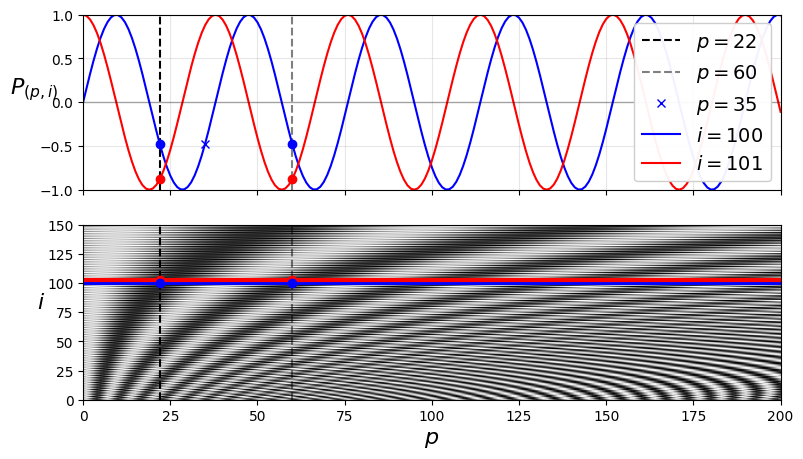

In [64]:
import matplotlib.pyplot as plt
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

Multi-Head Attention

In [65]:
N = 2
# instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128
# for the first Dense Layer in each Feed Forward Block
encoder_pad_mask = tf.keras.layers.Lambda(lambda x: tf.math.not_equal(x, 0))(encoder_input_ids)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(
    num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
  Z  = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  Z = tf.keras.layers.Dense(n_units, activation='relu') (Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.Dropout(dropout_rate)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [66]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs,decoder_inputs], outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=1,
          validation_data=((X_valid, X_valid_dec), Y_valid))

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.8895 - loss: 0.6150 - val_accuracy: 0.9047 - val_loss: 0.3796


In [67]:
translate("I like soccer and also going to the beach")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'me gusta fútbol gusta también a la la'